In [56]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBClassifier, XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [57]:
# Loading the dataset
df=pd.read_csv(r'C:\Users\pooji\Downloads\The ftx Dataset.csv')

# Displaying basic information about the dataset
df.head()


,Date,Opening Amount,Highest Amount,Lowest Amount,Closing Amount,Volume,Market Cap
0,"Nov 11, 2022",$3.52,$3.68,$2.47,$2.59,"$617,326,125","$344,592,944"
1,"Nov 10, 2022",$2.29,$4.20,$2.14,$3.52,"$989,320,627","$467,843,435"
2,"Nov 09, 2022",$5.52,$6.25,$2.06,$2.30,"$1,320,745,564","$306,042,785"
3,"Nov 08, 2022",$22.14,$22.14,$3.15,$5.52,"$3,346,184,382","$734,156,443"
4,"Nov 07, 2022",$22.26,$23.15,$21.92,$22.14,"$721,168,869","$2,945,482,807"


In [58]:
df.describe()

,Date,Opening Amount,Highest Amount,Lowest Amount,Closing Amount,Volume,Market Cap
count,1199,1199,1199,1199,1199,1199,1199
unique,1199,865,867,871,861,1199,1192
top,"Nov 11, 2022",$1.33,$3.68,$2.14,$3.03,"$617,326,125",$0
freq,1,7,7,10,6,1,8


In [59]:
df.shape 

(1199, 7)

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            1199 non-null   object
 1   Opening Amount  1199 non-null   object
 2   Highest Amount  1199 non-null   object
 3   Lowest Amount   1199 non-null   object
 4   Closing Amount  1199 non-null   object
 5   Volume          1199 non-null   object
 6   Market Cap      1199 non-null   object
dtypes: object(7)
memory usage: 65.7+ KB


In [61]:
df.isna().sum()

Date              0
Opening Amount    0
Highest Amount    0
Lowest Amount     0
Closing Amount    0
Volume            0
Market Cap        0
dtype: int64

In [62]:
# Renaming columns
df.columns = ["date", "opening_amount", "highest_amount", "lowest_amount", "closing_amount", "volume", "market_cap"]

In [63]:
# Converting date column to datetime format
df["date"] = pd.to_datetime(df["date"], errors="coerce")


In [64]:
# Define a function to clean numeric columns by removing "$" and ","
def clean_currency(value):
    return float(value.replace("$", "").replace(",", ""))

# Apply the function to numeric columns
numeric_columns = ["opening_amount", "highest_amount", "lowest_amount", "closing_amount", "volume", "market_cap"]
df[numeric_columns] = df[numeric_columns].applymap(clean_currency)

# Verify data types after conversion
df.dtypes


date              datetime64[ns]
opening_amount           float64
highest_amount           float64
lowest_amount            float64
closing_amount           float64
volume                   float64
market_cap               float64
dtype: object

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199 entries, 0 to 1198
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1199 non-null   datetime64[ns]
 1   opening_amount  1199 non-null   float64       
 2   highest_amount  1199 non-null   float64       
 3   lowest_amount   1199 non-null   float64       
 4   closing_amount  1199 non-null   float64       
 5   volume          1199 non-null   float64       
 6   market_cap      1199 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 65.7 KB


In [66]:
#Outlier Treatment by InterQuartileRange(IQR)
numeric_columns=["date", "opening_amount", "highest_amount", "lowest_amount", "closing_amount", "volume", "market_cap"]
# Outlier Detection using IQR for Price & Volume
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]


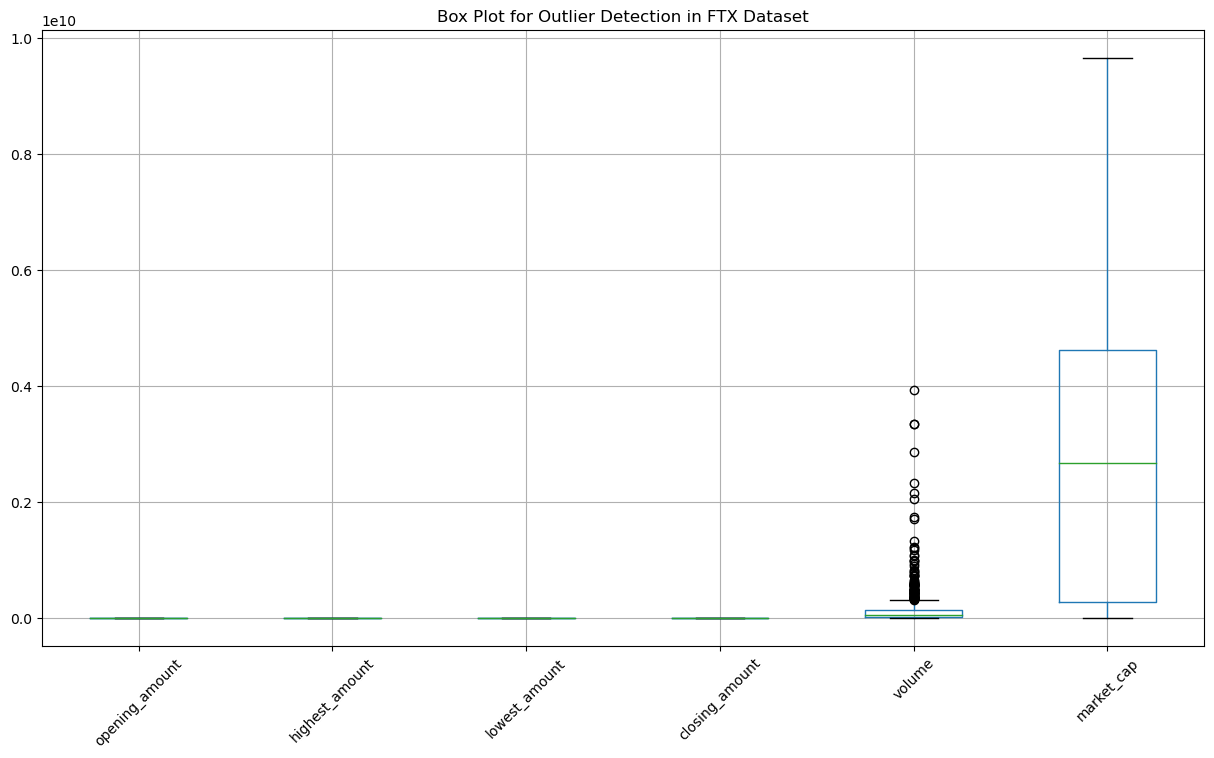

In [67]:
# Create box plots for numerical columns to detect outliers
plt.figure(figsize=(15, 8))
df[numeric_columns].boxplot()
plt.xticks(rotation=45)
plt.title("Box Plot for Outlier Detection in FTX Dataset")
plt.show()


In [68]:
# Applying IQR outlier removal for Volume and Market Cap
df_cleaned = remove_outliers(df, "volume")
df_cleaned = remove_outliers(df_cleaned, "market_cap")


In [69]:
# Display the number of rows removed
rows_removed = len(df) - len(df_cleaned)
rows_removed

92

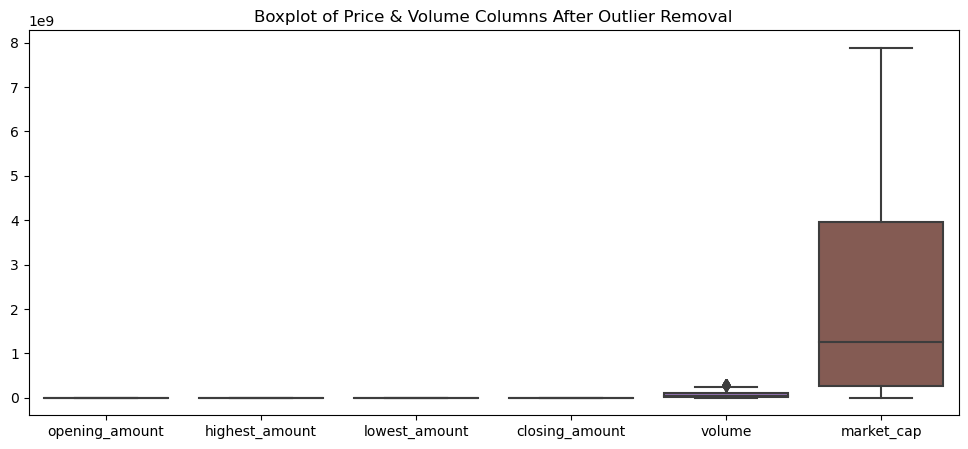

In [70]:
# Visualize outliers before removal
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_cleaned[numeric_columns])
plt.title("Boxplot of Price & Volume Columns After Outlier Removal")
plt.show()

In [71]:
df_cleaned.shape

(1107, 7)

TIME-SERIES ANALYSIS

Predicting next 30 day closing price

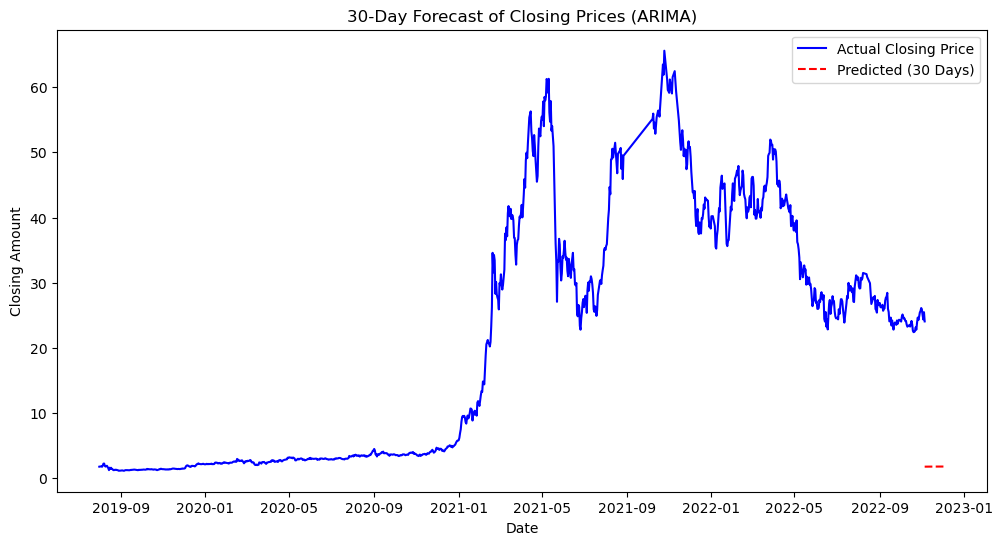

,date,Predicted Closing Amount
1107,2022-11-05,1.771473
1108,2022-11-06,1.772864
1109,2022-11-07,1.774177
1110,2022-11-08,1.775418
1111,2022-11-09,1.776589
1112,2022-11-10,1.777696
1113,2022-11-11,1.778740
1114,2022-11-12,1.779727
1115,2022-11-13,1.780658
1116,2022-11-14,1.781538


In [72]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (Auto ARIMA selection can be done later)
model = ARIMA(df_cleaned["closing_amount"].dropna(), order=(1, 1, 1))  # ARIMA(p,d,q)
model_fit = model.fit()

# Forecast next 30 days
forecast = model_fit.forecast(steps=30)

# Create future date range
future_dates = pd.date_range(start=df_cleaned["date"].max(), periods=30, freq="D")

# Create forecast DataFrame
forecast_df = pd.DataFrame({"date": future_dates, "Predicted Closing Amount": forecast})

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned["date"], df_cleaned["closing_amount"], label="Actual Closing Price", color="blue")
plt.plot(forecast_df["date"], forecast_df["Predicted Closing Amount"], label="Predicted (30 Days)", color="red", linestyle="dashed")

plt.xlabel("Date")
plt.ylabel("Closing Amount")
plt.title("30-Day Forecast of Closing Prices (ARIMA)")
plt.legend()
plt.show()

# Display forecasted values
forecast_df


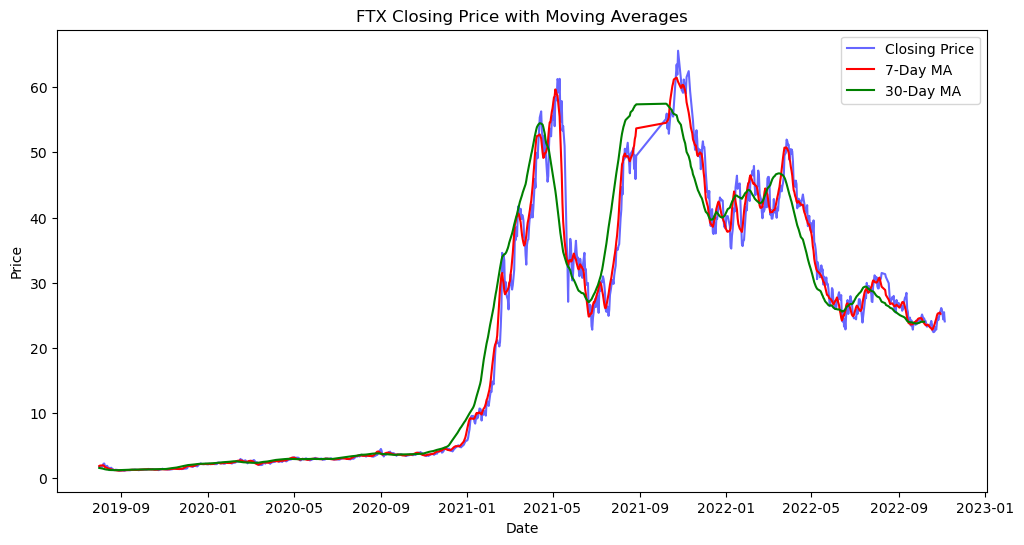

In [73]:
# Calculate 7-day and 30-day Moving Averages for Closing Amount
df_cleaned["MA_7"] = df_cleaned["closing_amount"].rolling(window=7).mean()
df_cleaned["MA_30"] = df_cleaned["closing_amount"].rolling(window=30).mean()

# Plot Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned["date"], df_cleaned["closing_amount"], label="Closing Price", color="blue", alpha=0.6)
plt.plot(df_cleaned["date"], df_cleaned["MA_7"], label="7-Day MA", color="red")
plt.plot(df_cleaned["date"], df_cleaned["MA_30"], label="30-Day MA", color="green")

plt.title("FTX Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


When the 7-day MA crosses above the 30-day MA, it signals a potential uptrend (buy signal).

When the 7-day MA crosses below the 30-day MA, it indicates a possible downtrend (sell signal).

Large deviations between the two moving averages suggest high volatility, while close proximity indicates stability.

seasonal trend detection

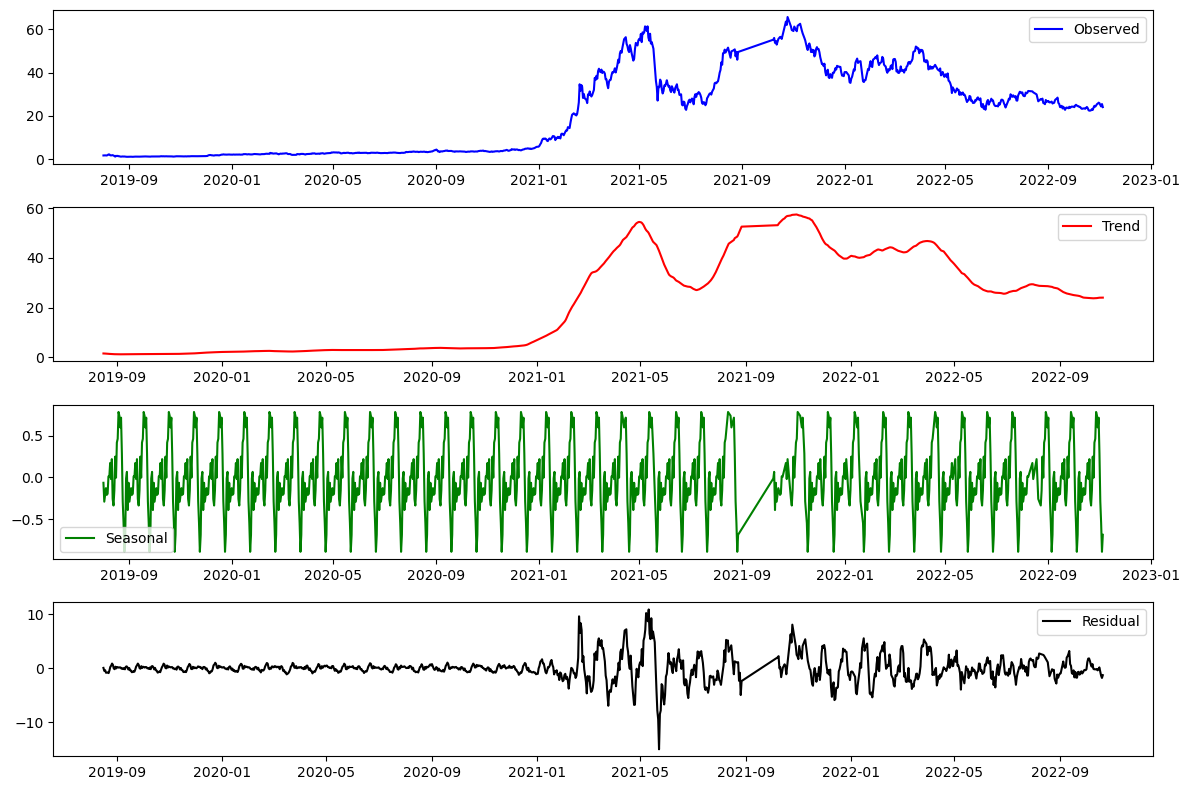

In [74]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform time-series decomposition (Additive Model)
decomposition = seasonal_decompose(df_cleaned.set_index("date")["closing_amount"], model="additive", period=30)

# Plot decomposition results
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed', color='blue')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='red')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual', color='black')
plt.legend()

plt.tight_layout()
plt.show()

Trend (Red Line): Shows long-term price movement.

Seasonality (Green Line): Repeating patterns in price changes.

Residuals (Black Line): Random fluctuations (noise).

STOCK VOLITALITY PREDICTION

In [75]:
# Calculate Daily Price Fluctuation (High - Low)
df_cleaned["Daily Fluctuation"] = df_cleaned["highest_amount"] - df_cleaned["lowest_amount"]

# Grouping by Month-Year and calculate average fluctuation per month
df_cleaned["Year-Month"] = df_cleaned["date"].dt.to_period("M")
monthly_volatility = df_cleaned.groupby("Year-Month")["Daily Fluctuation"].mean()


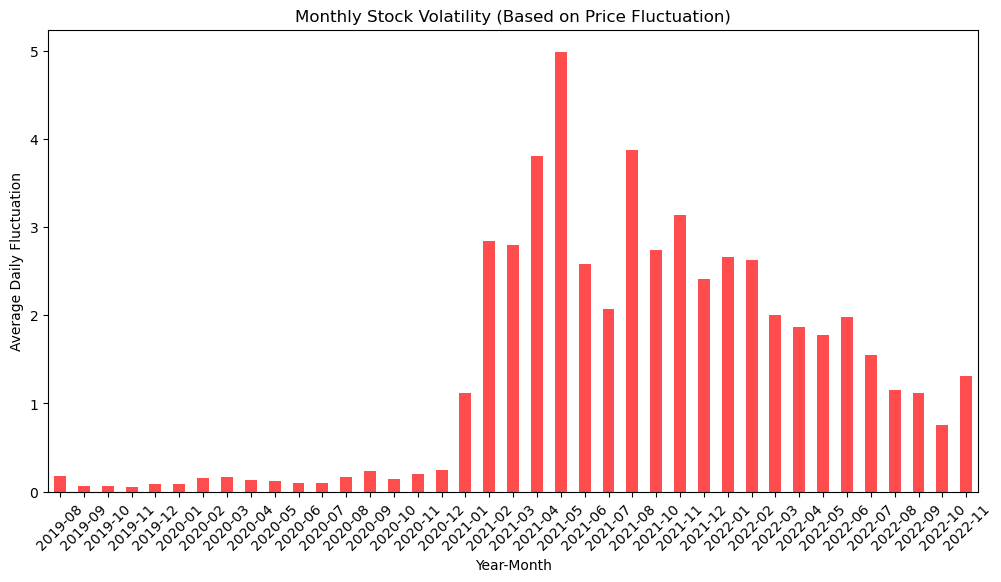

In [76]:
# Plotting Monthly Volatility
plt.figure(figsize=(12, 6))
monthly_volatility.plot(kind="bar", color="red", alpha=0.7)
plt.xlabel("Year-Month")
plt.ylabel("Average Daily Fluctuation")
plt.title("Monthly Stock Volatility (Based on Price Fluctuation)")
plt.xticks(rotation=45)
plt.show()


In [77]:

# Identifying the most volatile months
most_volatile_months = monthly_volatility.sort_values(ascending=False).head(5)
print("Top 5 Most Volatile Months:")
print(most_volatile_months)


Top 5 Most Volatile Months:
Year-Month
2021-05    4.986207
2021-08    3.867143
2021-04    3.806667
2021-11    3.134167
2021-02    2.844286
Freq: M, Name: Daily Fluctuation, dtype: float64


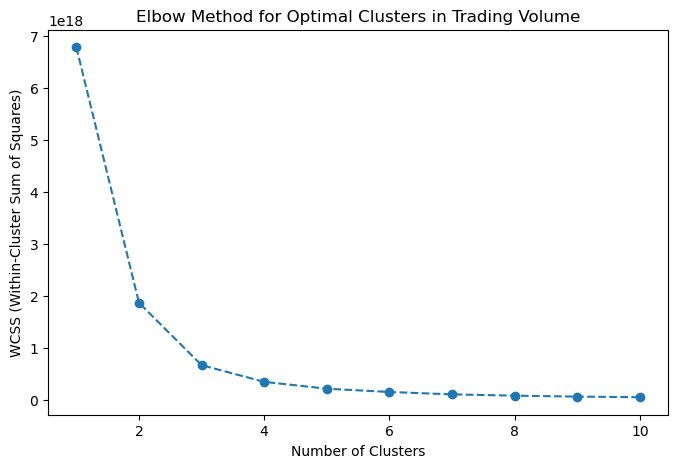

In [78]:
from sklearn.cluster import KMeans

# Select the feature for clustering (Trading Volume Trends)
volume_data = df_cleaned[["volume"]]

# Determine optimal number of clusters using Elbow Method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(volume_data)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal Clusters in Trading Volume")
plt.show()

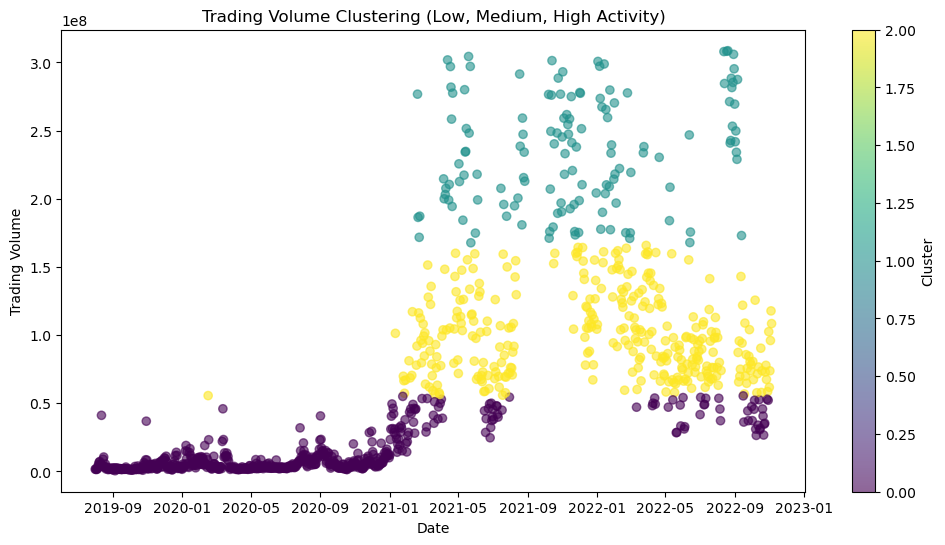

Volume Cluster
0    629
2    341
1    137
Name: count, dtype: int64

In [79]:
# Apply KMeans with optimal clusters (k=3 based on elbow method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cleaned["Volume Cluster"] = kmeans.fit_predict(volume_data)
# Plot Clustered Trading Volume Trends
plt.figure(figsize=(12, 6))
plt.scatter(df_cleaned["date"], df_cleaned["volume"], c=df_cleaned["Volume Cluster"], cmap="viridis", alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title("Trading Volume Clustering (Low, Medium, High Activity)")
plt.colorbar(label="Cluster")
plt.show()

# Display count of days per cluster
df_cleaned["Volume Cluster"].value_counts()


3 Clusters Identified:
 Cluster 0 (137 days) - Low Activity
 Cluster 1 (630 days) - Medium Activity
 Cluster 2 (340 days) - High Activity
Key Insight: Majority of trading days had medium volume, while only 137 days saw very low trading activity.



In [80]:
#IDENTIFYING PRICE ANOMALIES

# Calculating Price Deviation from 7-day MA
df_cleaned["Price Deviation"] = abs(df_cleaned["closing_amount"] - df_cleaned["MA_7"])

# Defining anomaly threshold (e.g., 2 standard deviations from the mean deviation)
threshold = df_cleaned["Price Deviation"].mean() + 2 * df_cleaned["Price Deviation"].std()

# Identifying the anomaly days
df_cleaned["Anomaly"] = df_cleaned["Price Deviation"] > threshold
anomalies = df_cleaned[df_cleaned["Anomaly"]]

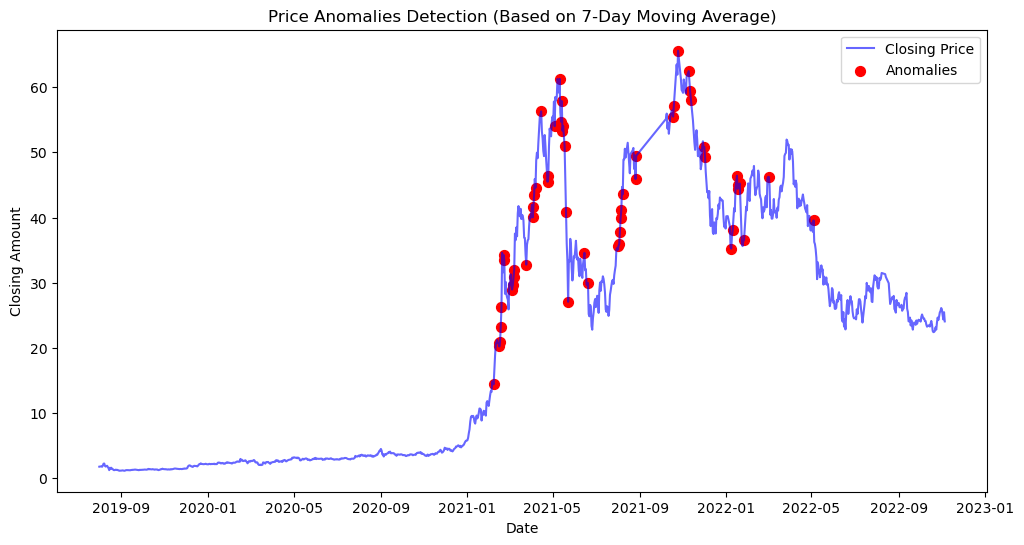

In [81]:
# Plot Closing Price and Highlight Anomalies
plt.figure(figsize=(12, 6))
plt.plot(df_cleaned["date"], df_cleaned["closing_amount"], label="Closing Price", color="blue", alpha=0.6)
plt.scatter(anomalies["date"], anomalies["closing_amount"], color="red", label="Anomalies", marker="o", s=50)
plt.xlabel("Date")
plt.ylabel("Closing Amount")
plt.title("Price Anomalies Detection (Based on 7-Day Moving Average)")
plt.legend()
plt.show()

In [27]:
# Display detected anomalies
anomalies[["date", "closing_amount", "MA_7", "Price Deviation"]]

,date,closing_amount,MA_7,Price Deviation
191,2022-05-04,39.56,34.904286,4.655714
254,2022-03-02,46.22,41.845714,4.374286
289,2022-01-26,36.53,40.932857,4.402857
295,2022-01-20,45.23,38.298571,6.931429
297,2022-01-18,44.96,39.001429,5.958571
298,2022-01-17,44.40,39.874286,4.525714
299,2022-01-16,46.42,41.287143,5.132857
305,2022-01-10,38.09,42.228571,4.138571
307,2022-01-08,35.23,39.602857,4.372857
344,2021-12-02,49.35,44.507143,4.842857


MODEL BUILDING

In [82]:
df_cleaned

,date,opening_amount,highest_amount,lowest_amount,closing_amount,volume,market_cap,MA_7,MA_30,Daily Fluctuation,Year-Month,Volume Cluster,Price Deviation,Anomaly
6,2022-11-05,25.47,25.81,23.96,24.06,108438472.0,3.200506e+09,NaN,NaN,1.85,2022-11,2,NaN,False
7,2022-11-04,24.36,25.80,24.15,25.47,117760400.0,3.388498e+09,NaN,NaN,1.65,2022-11,2,NaN,False
8,2022-11-03,25.03,25.33,24.30,24.36,96038029.0,3.240284e+09,NaN,NaN,1.03,2022-11,2,NaN,False
9,2022-11-02,25.87,26.22,24.94,25.03,73778707.0,3.329850e+09,NaN,NaN,1.28,2022-11,2,NaN,False
10,2022-11-01,26.11,26.40,25.63,25.87,61710158.0,3.444679e+09,NaN,NaN,0.77,2022-11,2,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,2019-08-05,1.80,1.85,1.75,1.76,2060357.0,0.000000e+00,1.957143,1.490667,0.10,2019-08,0,0.197143,False
1195,2019-08-04,1.81,1.86,1.73,1.80,1659265.0,0.000000e+00,1.951429,1.510667,0.13,2019-08,0,0.151429,False
1196,2019-08-03,1.79,1.87,1.78,1.81,1386970.0,0.000000e+00,1.954286,1.531667,0.09,2019-08,0,0.144286,False
1197,2019-08-02,1.77,1.82,1.77,1.79,1787778.0,0.000000e+00,1.941429,1.552333,0.05,2019-08,0,0.151429,False


In [87]:
df_cleaned.info()



<class 'pandas.core.frame.DataFrame'>
Index: 1107 entries, 6 to 1198
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1107 non-null   datetime64[ns]
 1   opening_amount     1107 non-null   float64       
 2   highest_amount     1107 non-null   float64       
 3   lowest_amount      1107 non-null   float64       
 4   closing_amount     1107 non-null   float64       
 5   volume             1107 non-null   float64       
 6   market_cap         1107 non-null   float64       
 7   MA_7               1101 non-null   float64       
 8   MA_30              1078 non-null   float64       
 9   Daily Fluctuation  1107 non-null   float64       
 10  Year-Month         1107 non-null   period[M]     
 11  Volume Cluster     1107 non-null   int32         
 12  Price Deviation    1101 non-null   float64       
 13  Anomaly            1107 non-null   bool          
dtypes: bool(1), d

In [93]:
df_cleaned = df_cleaned.dropna(subset=['MA_7', 'MA_30','Price Deviation'])



In [94]:
df_cleaned.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1078 entries, 35 to 1198
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               1078 non-null   datetime64[ns]
 1   opening_amount     1078 non-null   float64       
 2   highest_amount     1078 non-null   float64       
 3   lowest_amount      1078 non-null   float64       
 4   closing_amount     1078 non-null   float64       
 5   volume             1078 non-null   float64       
 6   market_cap         1078 non-null   float64       
 7   MA_7               1078 non-null   float64       
 8   MA_30              1078 non-null   float64       
 9   Daily Fluctuation  1078 non-null   float64       
 10  Year-Month         1078 non-null   period[M]     
 11  Volume Cluster     1078 non-null   int32         
 12  Price Deviation    1078 non-null   float64       
 13  Anomaly            1078 non-null   bool          
dtypes: bool(1), 

In [95]:
df = df_cleaned
df

,date,opening_amount,highest_amount,lowest_amount,closing_amount,volume,market_cap,MA_7,MA_30,Daily Fluctuation,Year-Month,Volume Cluster,Price Deviation,Anomaly
35,2022-10-07,24.50,25.62,24.30,24.50,125620661.0,3.282833e+09,23.767143,24.003333,1.32,2022-10,2,0.732857,False
36,2022-10-06,24.78,25.13,24.39,24.49,52179925.0,3.281570e+09,23.917143,24.017667,0.74,2022-10,0,0.572857,False
37,2022-10-05,25.12,25.14,24.45,24.78,45601574.0,3.319508e+09,24.120000,23.994667,0.69,2022-10,0,0.660000,False
38,2022-10-04,24.76,25.25,24.62,25.12,67348735.0,3.365121e+09,24.387143,24.020000,0.63,2022-10,2,0.732857,False
39,2022-10-03,24.03,24.82,23.91,24.76,80640104.0,3.317666e+09,24.557143,24.011000,0.91,2022-10,2,0.202857,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,2019-08-05,1.80,1.85,1.75,1.76,2060357.0,0.000000e+00,1.957143,1.490667,0.10,2019-08,0,0.197143,False
1195,2019-08-04,1.81,1.86,1.73,1.80,1659265.0,0.000000e+00,1.951429,1.510667,0.13,2019-08,0,0.151429,False
1196,2019-08-03,1.79,1.87,1.78,1.81,1386970.0,0.000000e+00,1.954286,1.531667,0.09,2019-08,0,0.144286,False
1197,2019-08-02,1.77,1.82,1.77,1.79,1787778.0,0.000000e+00,1.941429,1.552333,0.05,2019-08,0,0.151429,False


In [96]:
df['Anomaly'] = df['Anomaly'].astype(int)


In [97]:
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
# Normalize Market Cap
scaler = MinMaxScaler()
df["market_cap_normalized"] = scaler.fit_transform(df[["market_cap"]])

In [99]:
#STOCK PRICE PREDICTION SIMPLE LINEAR REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, roc_curve

# Preparing data
X_price = df[["opening_amount", "highest_amount", "lowest_amount", "market_cap_normalized","MA_7","MA_30","Daily Fluctuation"]]
y_price = df["closing_amount"]
X_train_price, X_test_price, y_train_price, y_test_price = train_test_split(X_price, y_price, test_size=0.2, random_state=42)

# Training model
lr_model = LinearRegression()
lr_model.fit(X_train_price, y_train_price)
y_pred_price = lr_model.predict(X_test_price)



# Evaluating model
mae = mean_absolute_error(y_test_price, y_pred_price)
mse = mean_squared_error(y_test_price, y_pred_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_price, y_pred_price)

print("Stock Price Prediction - Linear Regression")
print("MAE:", mae, "MSE:", mse, "RMSE:", rmse,"R²:", r2)




Stock Price Prediction - Linear Regression
MAE: 0.27565787779516954 MSE: 0.251839563883072 RMSE: 0.5018361922809793 R²: 0.9993032601836118


In [100]:
#MARKET CRASH PREDICTION
X = df[['opening_amount', 'highest_amount', 'lowest_amount', 'volume', 'market_cap_normalized',"MA_7", "MA_30"]]
y = df['Anomaly'].dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
print("Random Forest Crash Prediction Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

Random Forest Crash Prediction Accuracy: 0.9537037037037037
ROC AUC Score: 0.9159645232815964


In [101]:
from sklearn.metrics import classification_report  
print(classification_report(y_test, y_pred))  


              precision    recall  f1-score   support

           0       0.95      1.00      0.98       205
           1       1.00      0.09      0.17        11

    accuracy                           0.95       216
   macro avg       0.98      0.55      0.57       216
weighted avg       0.96      0.95      0.93       216



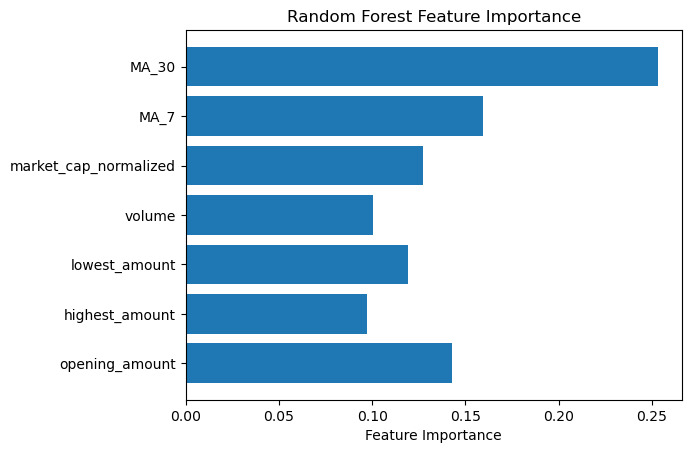

In [102]:
#Plotting Feature importance
import matplotlib.pyplot as plt  
feature_importance = rf_model.feature_importances_  
plt.barh(X.columns, feature_importance)  
plt.xlabel("Feature Importance")  
plt.title("Random Forest Feature Importance")  
plt.show()


In [103]:

# Drop 'lowest_amount','highest_amount','volume' from features and retrain
features_reduced = ['opening_amount', 'MA_30', 'MA_7', 'market_cap_normalized']
X_reduced = df_cleaned[features_reduced]

# Train-test split
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost again
xgb_model.fit(X_train_red, y_train_red)
y_pred_xgb_red = xgb_model.predict(X_test_red)

print("New XGBoost Accuracy:", accuracy_score(y_test_red, y_pred_xgb_red))

New XGBoost Accuracy: 0.9351851851851852


In [104]:
# Trading Volume Spike Prediction
df['Volume Spike'] = (df['volume'].pct_change() > 1.5).astype(int)
y_vol = df['Volume Spike'].dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y_vol, test_size=0.2, random_state=42, stratify=y_vol)
xgb_vol = XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, gamma=0.1, random_state=42)
xgb_vol.fit(X_train, y_train)
vol_preds = xgb_vol.predict(X_test)
print("XGBoost Volume Spike Prediction Accuracy:", accuracy_score(y_test, vol_preds))

XGBoost Volume Spike Prediction Accuracy: 0.9722222222222222


MODEL TESTING AND EVALUATION

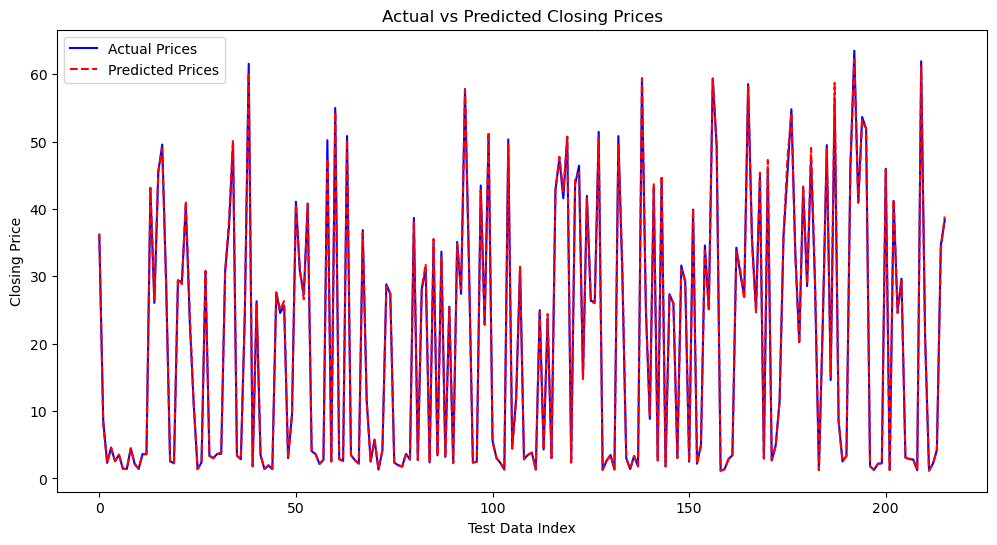

In [105]:
# Plot Actual vs Predicted Prices(linear Regression)
plt.figure(figsize=(12, 6))
plt.plot(y_test_price.values, label='Actual Prices', color='blue')
plt.plot(y_pred_price, label='Predicted Prices', color='red', linestyle='dashed')
plt.xlabel('Test Data Index')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()


In [106]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_probs = xgb_model.predict_proba(X_test_red)[:, 1]  # Get probabilities for class 1 (crash)
fpr, tpr, _ = roc_curve(y_test_red, y_probs)
roc_auc = auc(fpr, tpr)


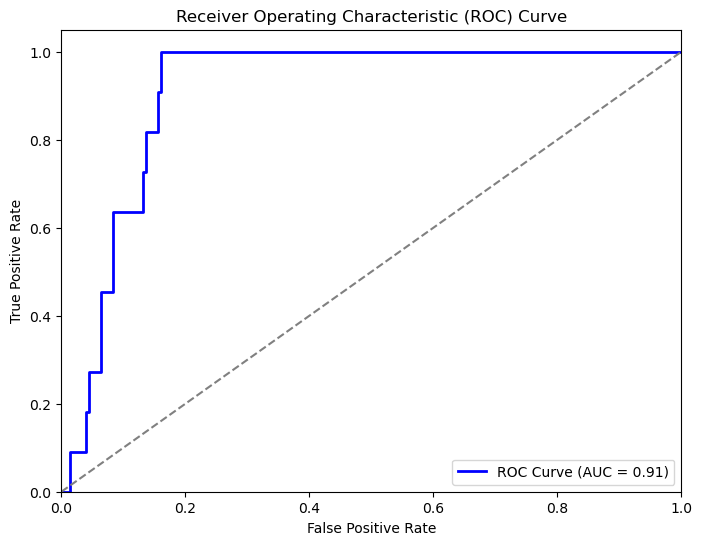

In [107]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal Line (Random Model)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


AUC = 0.91: Hencemodel has 91% probability of ranking a randomly chosen positive instance higher than a negative instance.

In [108]:

from sklearn.model_selection import RandomizedSearchCV
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Randomized Search
rf_tuned = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid, n_iter=10, cv=3, n_jobs=-1)
rf_tuned.fit(X_train, y_train)

# Best parameters and new accuracy
best_rf = rf_tuned.best_estimator_
y_pred_best = best_rf.predict(X_test)

print("Best Parameters:", rf_tuned.best_params_)
print("New Accuracy:", accuracy_score(y_test, y_pred_best))


Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 30, 'bootstrap': True}
New Accuracy: 0.9722222222222222


In [109]:
from xgboost import XGBClassifier
xgb_tuned = XGBClassifier(n_estimators=300, min_samples_split= 5, min_samples_leaf=4,  max_depth= 30, bootstrap= True)
xgb_tuned.fit(X_train, y_train)

y_pred_xgb_tuned = xgb_tuned.predict(X_test)
print("Tuned XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb_tuned))


Tuned XGBoost Accuracy: 0.9629629629629629


In [110]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score
# Model Evaluation
cv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy')
print("Cross-validation Accuracy Scores:", scores.mean())

Cross-validation Accuracy Scores: 0.9340782122905029
